In [1]:
import lightning as L
import numpy as np

from txtox.data.datamodules import AnnDataDataModule
from txtox.models.simple import LitMLPv0
from txtox.utils import get_paths

paths = get_paths()
expname = "20241007_123327_VISp"
checkpoint_path = paths["data_root"] + f"checkpoints/{expname}"
datamodule = AnnDataDataModule(data_dir=paths["data_root"], file_names=["VISp.h5ad"], batch_size=100)
model = LitMLPv0.load_from_checkpoint(
    checkpoint_path + "/epoch=79-val_rmse_overall=1.47.ckpt", input_size=500, n_labels=126
)

In [2]:
# model predictions on entire dataset
trainer = L.Trainer()
predictions = trainer.predict(model, datamodule=datamodule)

xyz_pred = np.concatenate([p[0] for p in predictions], axis=0)
celltype_pred = np.concatenate([p[1] for p in predictions], axis=0)
del predictions

xyz = []
celltype = []

for batch in datamodule.predict_dataloader():
    _, xyz_batch, celltype_batch = batch
    xyz.append(xyz_batch.numpy())
    celltype.append(celltype_batch.numpy().reshape(-1))

xyz_true = np.concatenate(xyz, axis=0)
celltype_true = np.concatenate(celltype, axis=0)
xyz_full_pred = xyz_pred.copy()
celltype_full_pred = celltype_pred.copy()

x_err, y_err, z_err = (np.linalg.norm(xyz_true[:, [i]] - xyz_pred[:, [i]], axis=1).mean() for i in range(3))

print(f"x_ccf_full_err: {x_err:0.3f} mm")
print(f"y_ccf_full_err: {y_err:0.3f} mm")
print(f"z_ccf_full_err: {z_err:0.3f} mm")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

x_ccf_full_err: 0.351 mm
y_ccf_full_err: 0.240 mm
z_ccf_full_err: 2.139 mm


In [3]:
# model predictions on test dataset
from torch.utils.data import DataLoader

trainer = L.Trainer()
test_dataloader = DataLoader(datamodule.data_test, batch_size=100, shuffle=False, pin_memory=True, num_workers=16)
predictions = trainer.predict(model, test_dataloader)

xyz_pred = np.concatenate([p[0] for p in predictions], axis=0)
celltype_pred = np.concatenate([p[1] for p in predictions], axis=0)
# del predictions

xyz = []
celltype = []

for batch in test_dataloader:
    _, xyz_batch, celltype_batch = batch
    xyz.append(xyz_batch.numpy())
    celltype.append(celltype_batch.numpy().reshape(-1))

xyz_true = np.concatenate(xyz, axis=0)
celltype_true = np.concatenate(celltype, axis=0)

x_err, y_err, z_err = (np.linalg.norm(xyz_true[:, [i]] - xyz_pred[:, [i]], axis=1).mean() for i in range(3))

print(f"x_ccf_err: {x_err:0.3f} mm")
print(f"y_ccf_err: {y_err:0.3f} mm")
print(f"z_ccf_err: {z_err:0.3f} mm")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

x_ccf_err: 0.357 mm
y_ccf_err: 0.243 mm
z_ccf_err: 2.280 mm


In [4]:
xyz_true.shape

(12376, 3)

In [5]:
# here we check properties of the visp data which is used as an example dataset.
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from txtox.utils import get_adata, get_paths

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [6]:
path = get_paths()["data_root"] + "VISp.h5ad"
adata = ad.read_h5ad(path)

In [7]:
adata.obs["x_pred"] = xyz_full_pred[:, 0]
adata.obs["y_pred"] = xyz_full_pred[:, 1]
adata.obs["z_pred"] = xyz_full_pred[:, 2]

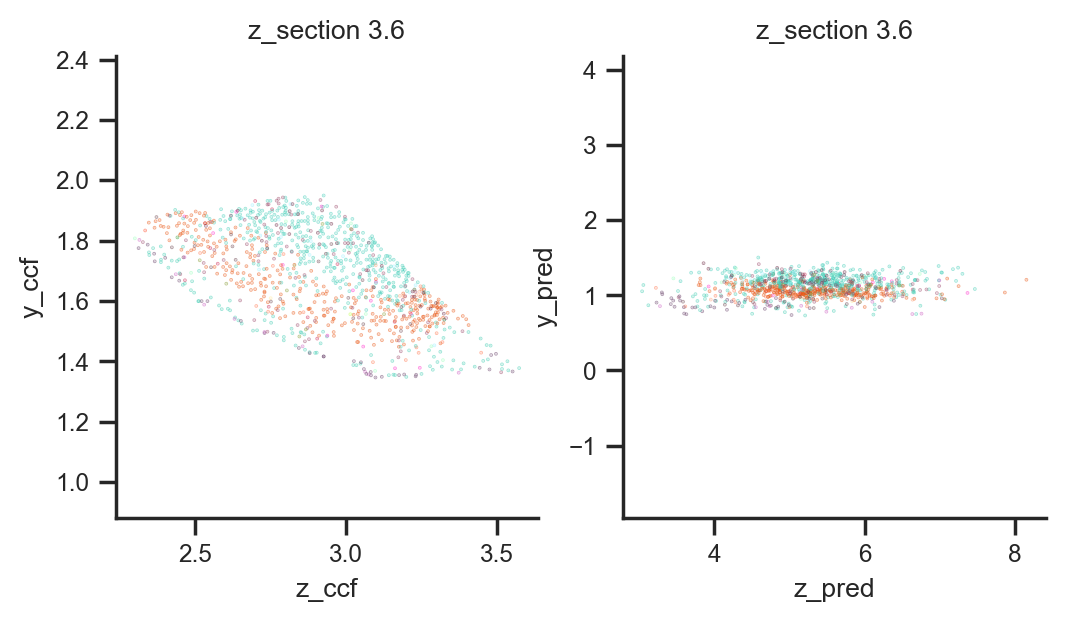

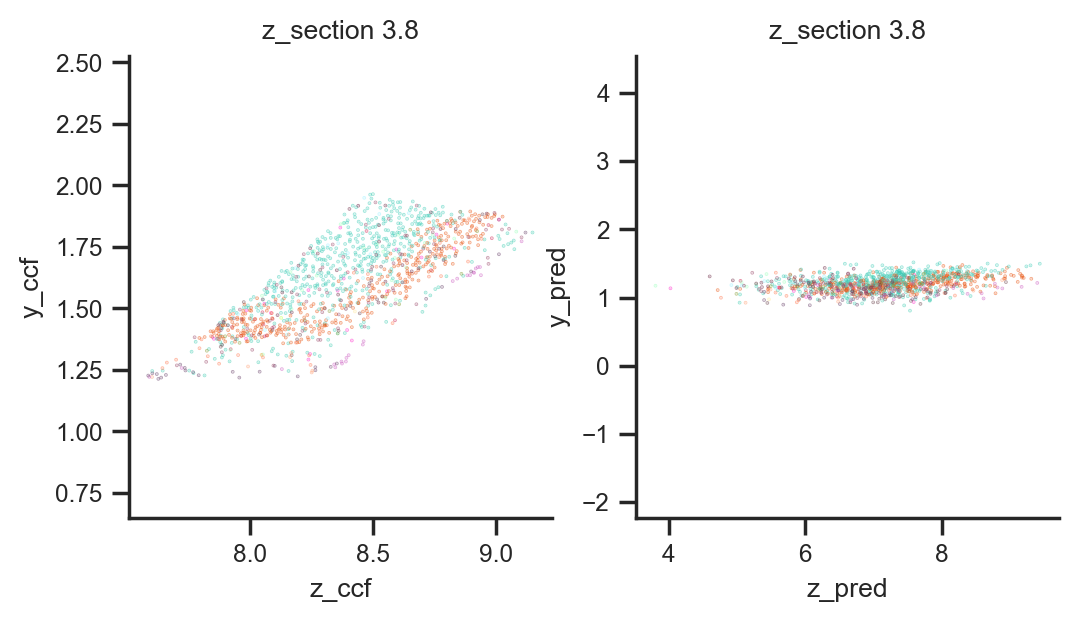

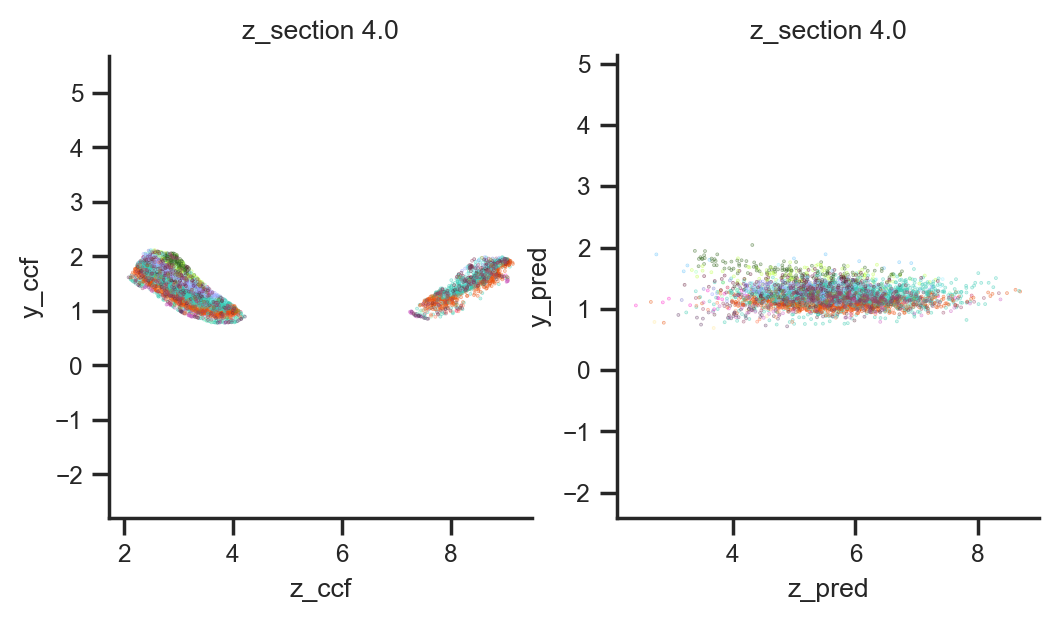

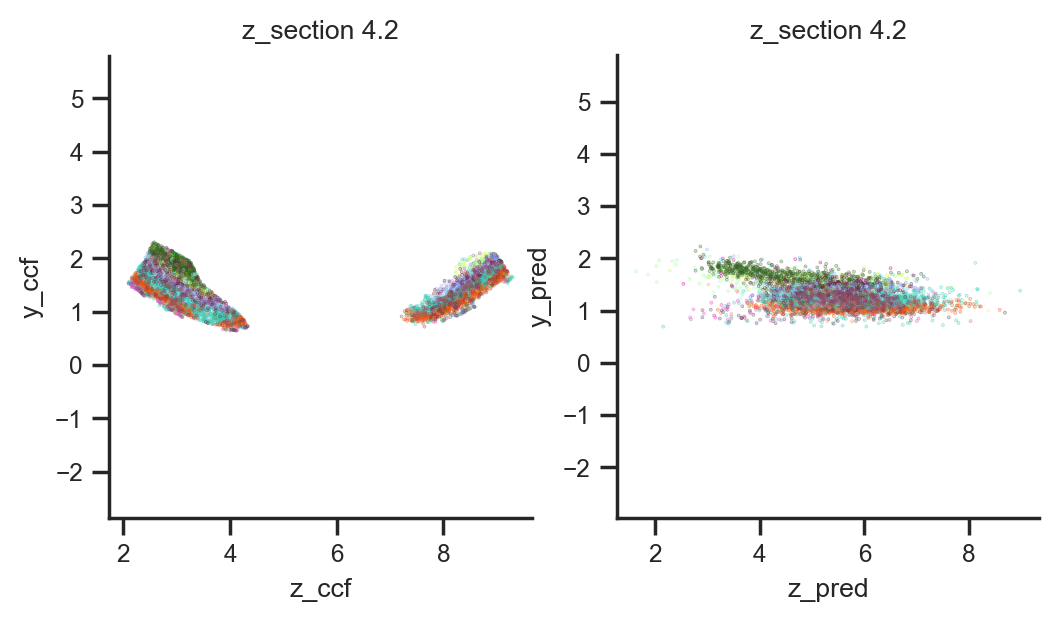

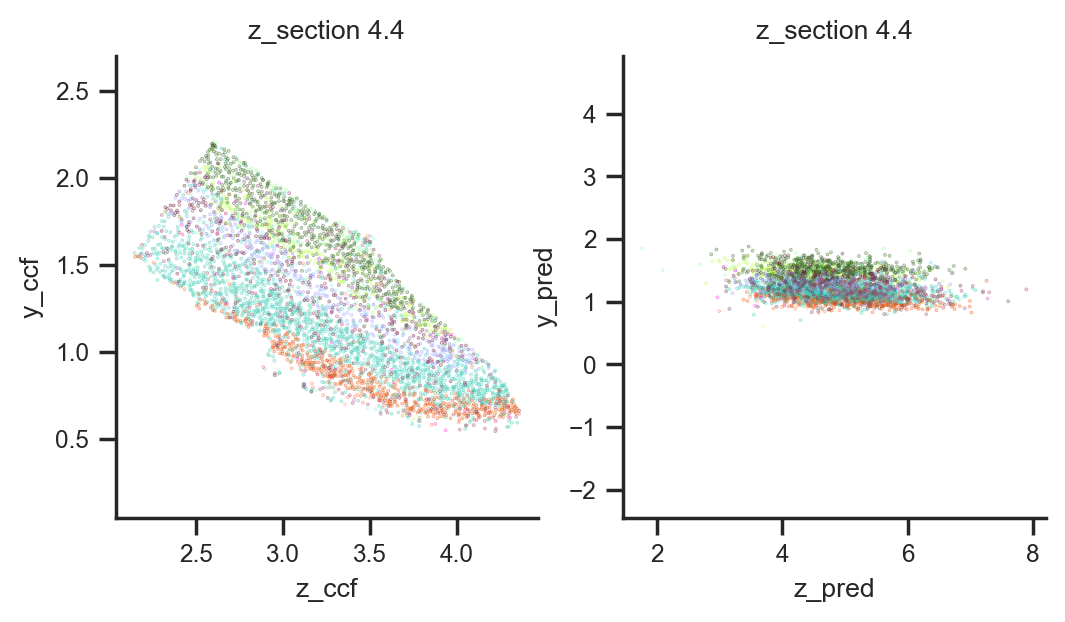

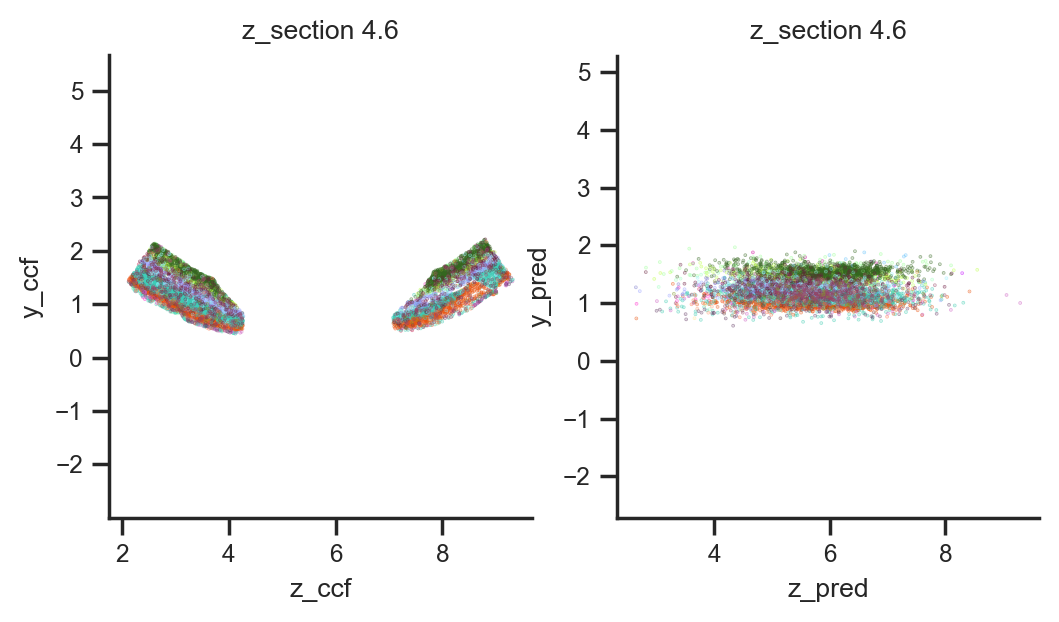

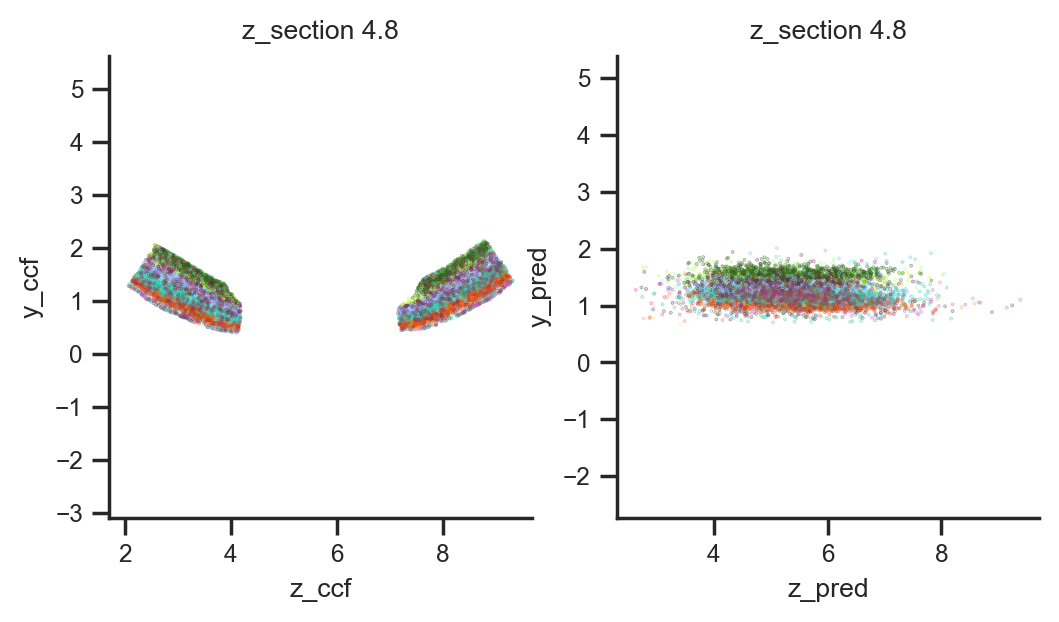

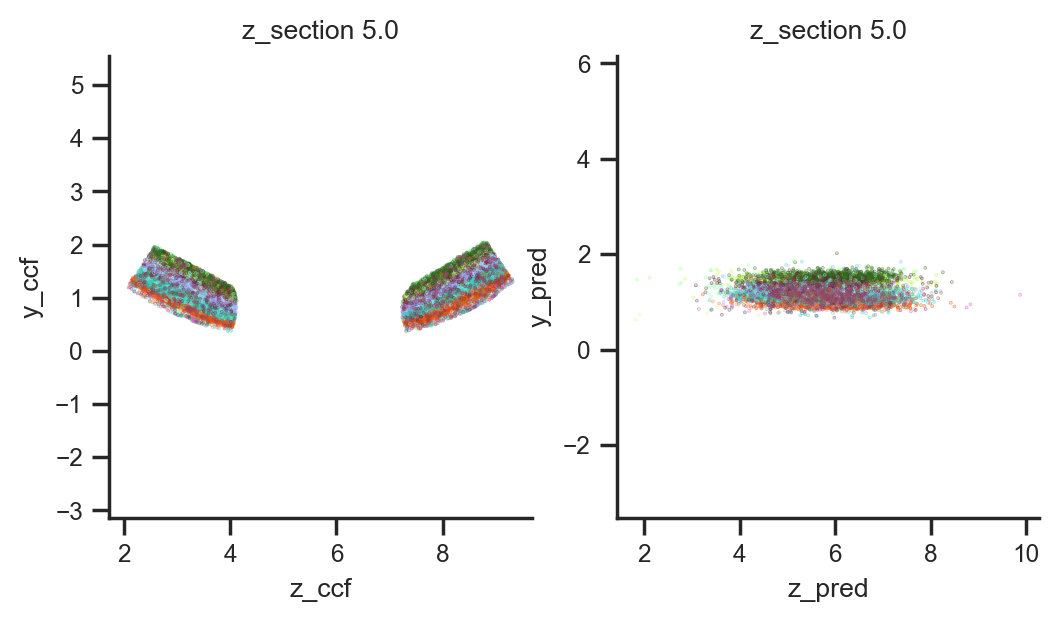

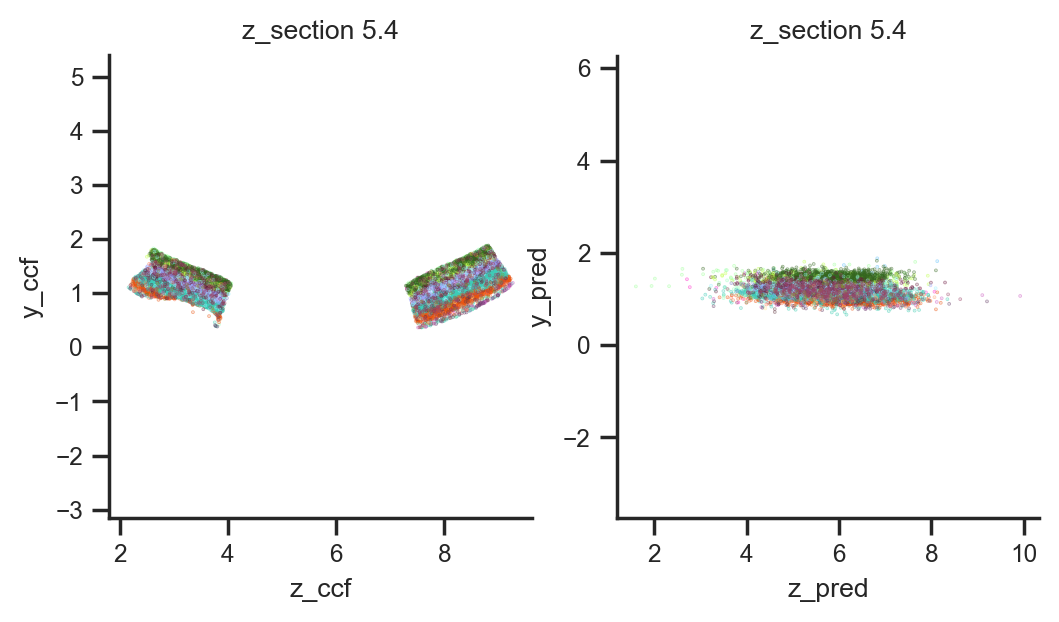

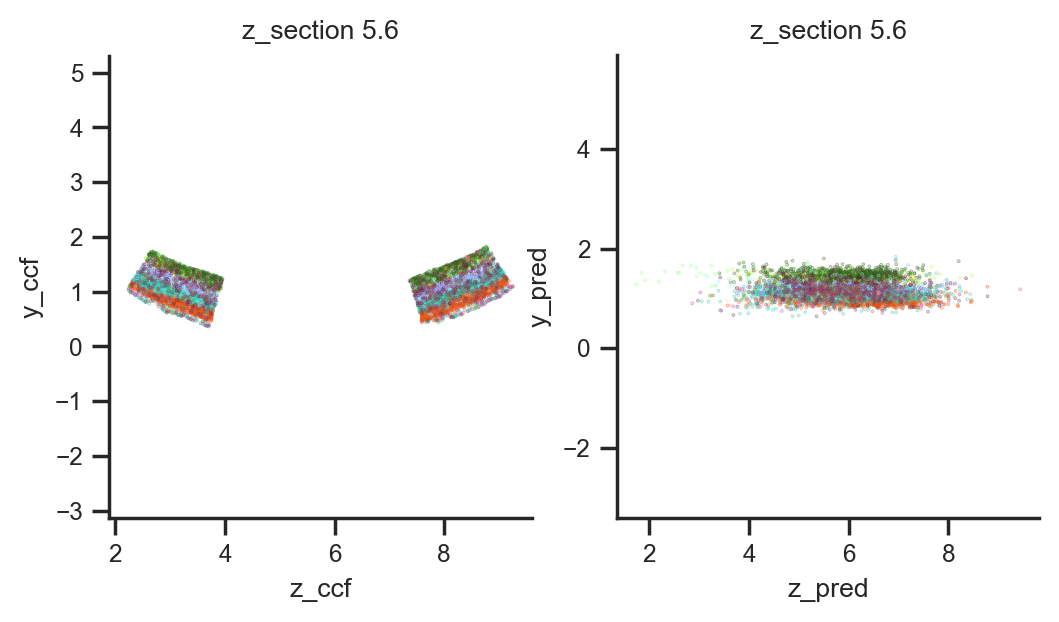

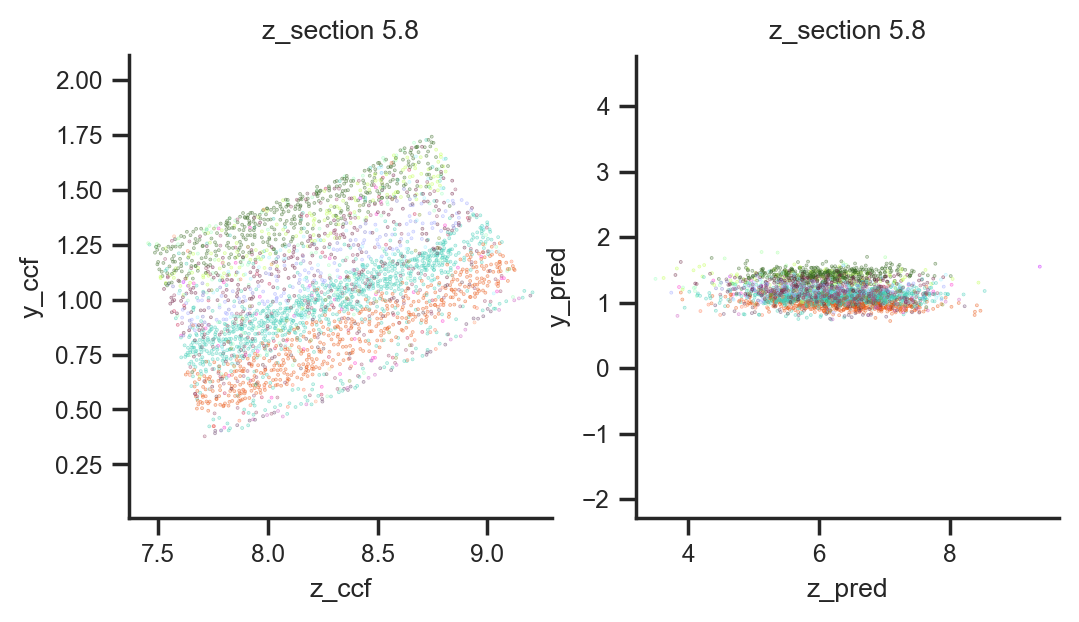

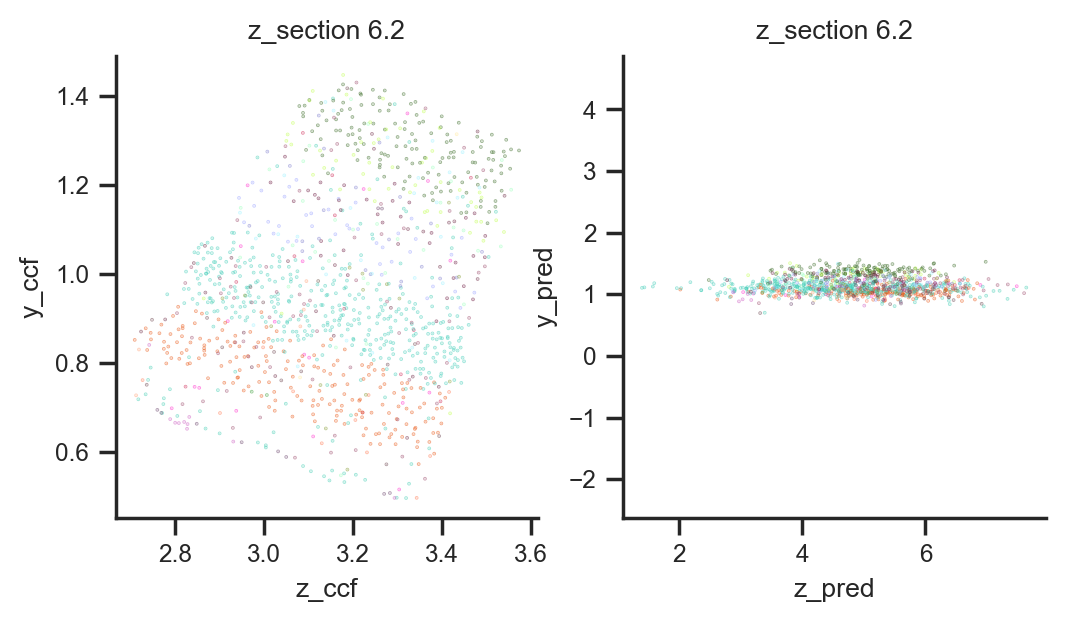

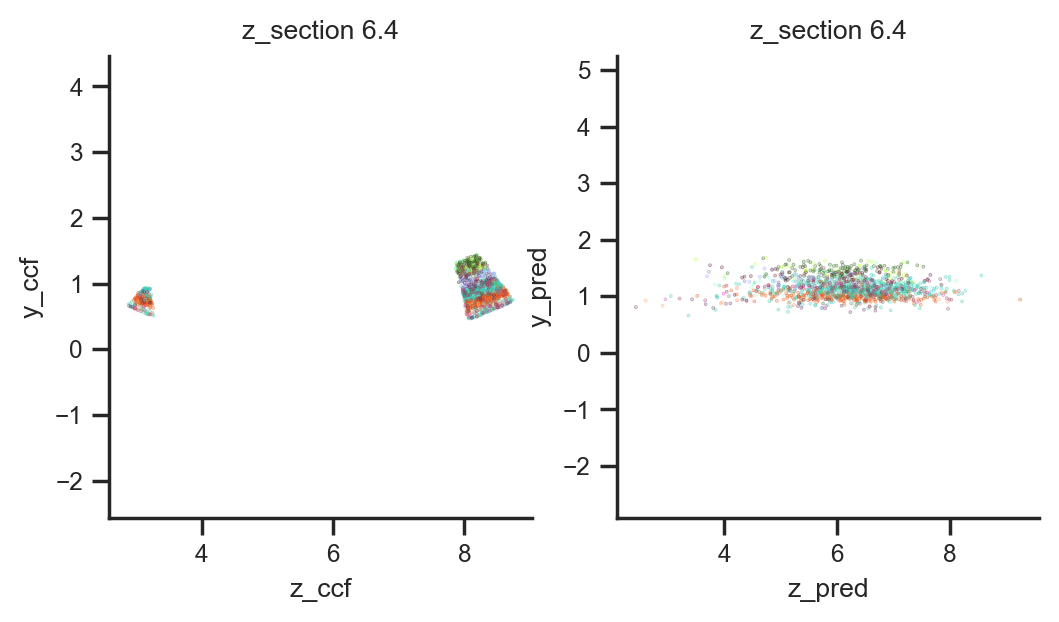

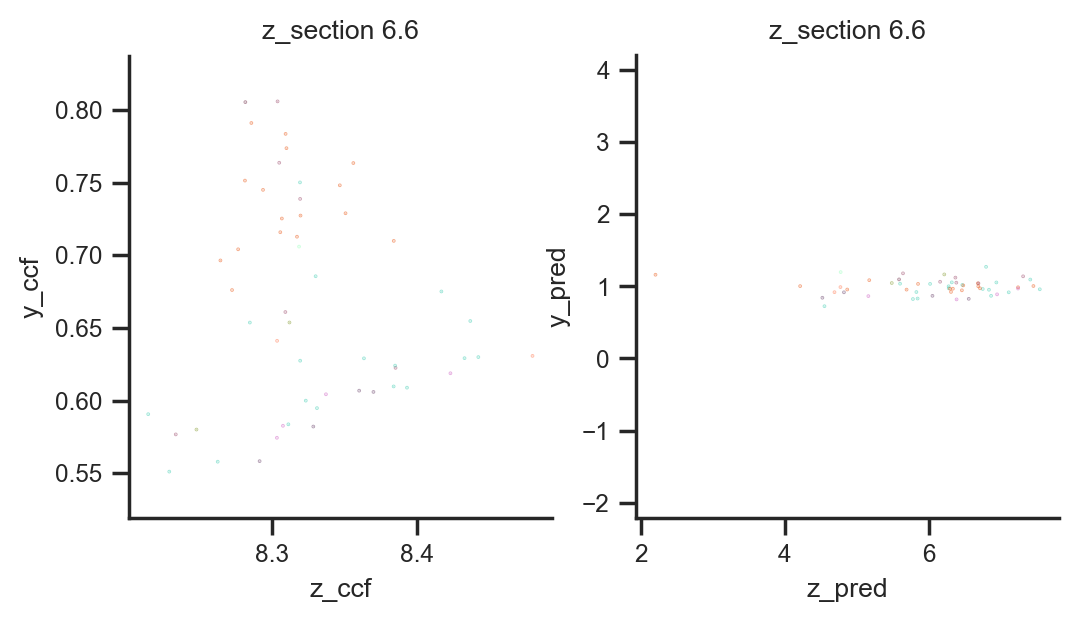

In [8]:
for section in np.sort(adata.obs["z_section"].unique()):
    ind = adata.obs["z_section"] == section

    # True values
    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].scatter(
        adata.obs["z_ccf"][ind],
        adata.obs["y_ccf"][ind],
        c=adata.obs["subclass_color"][ind],
        s=0.1,
        alpha=0.5,
        label=section,
    )
    ax[0].axis("equal")
    ax[0].set(xlabel="z_ccf", ylabel="y_ccf", title=f"z_section {section:0.1f}")

    # Predicted values
    ax[1].scatter(
        adata.obs["z_pred"][ind],
        adata.obs["y_pred"][ind],
        c=adata.obs["subclass_color"][ind],
        s=0.1,
        alpha=0.5,
        label=section,
    )
    ax[1].axis("equal")
    ax[1].set(xlabel="z_pred", ylabel="y_pred", title=f"z_section {section:0.1f}")

    plt.show()